In [1]:
%run lgs03a_data_unification.ipynb

In [2]:
from matplotlib.lines import Line2D

# Correlation of mutation effects across genes

Neutral/near-neutral mutations tends to stay neutral, and lethal ones stay lethal, but no correlation between the effects of mutations in different backgrounds beyond that.

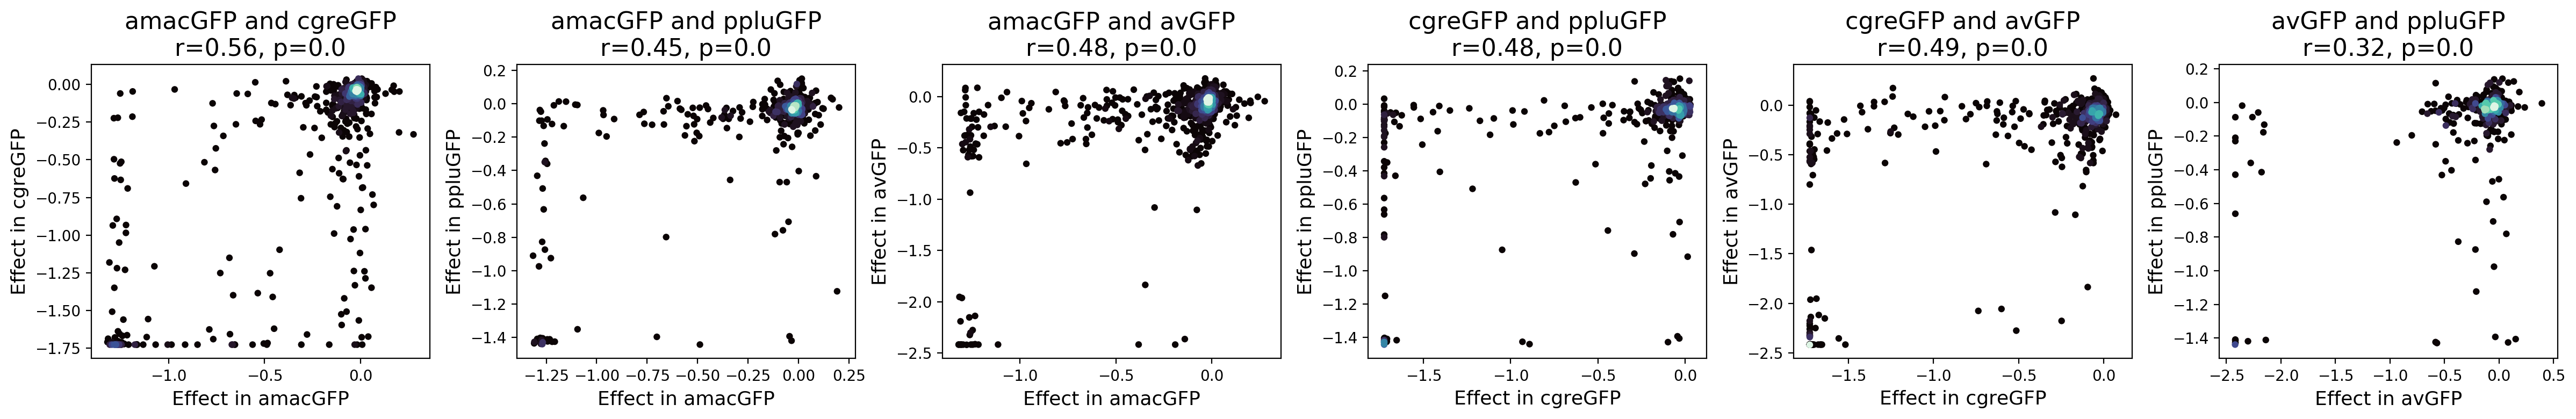

In [3]:
axes = subplots(nplots=6, nplots_per_row=6)
gene_pairs = [('amac','cgre'),('amac','pplu'),('amac','av'),('cgre','pplu'),('cgre','av'),('av','pplu')]

for ax,pair in zip(axes, gene_pairs):
    a = df_effects_singles['effect_in_'+pair[0]]
    b = df_effects_singles['effect_in_'+pair[1]]
    corr = scipy.stats.spearmanr(a,b, nan_policy='omit')
    plt.sca(ax)
    density_plot(np.array(a), np.array(b), s=20, cmap='mako')
    label_plot_axis(x = 'Effect in %sGFP' % pair[0], y = 'Effect in %sGFP' % pair[1],
                   t = '%sGFP and %sGFP\nr=%s, p=%s' % (pair[0], pair[1], round(corr[0],2), round(corr[1], 5)))
    
plt.tight_layout()

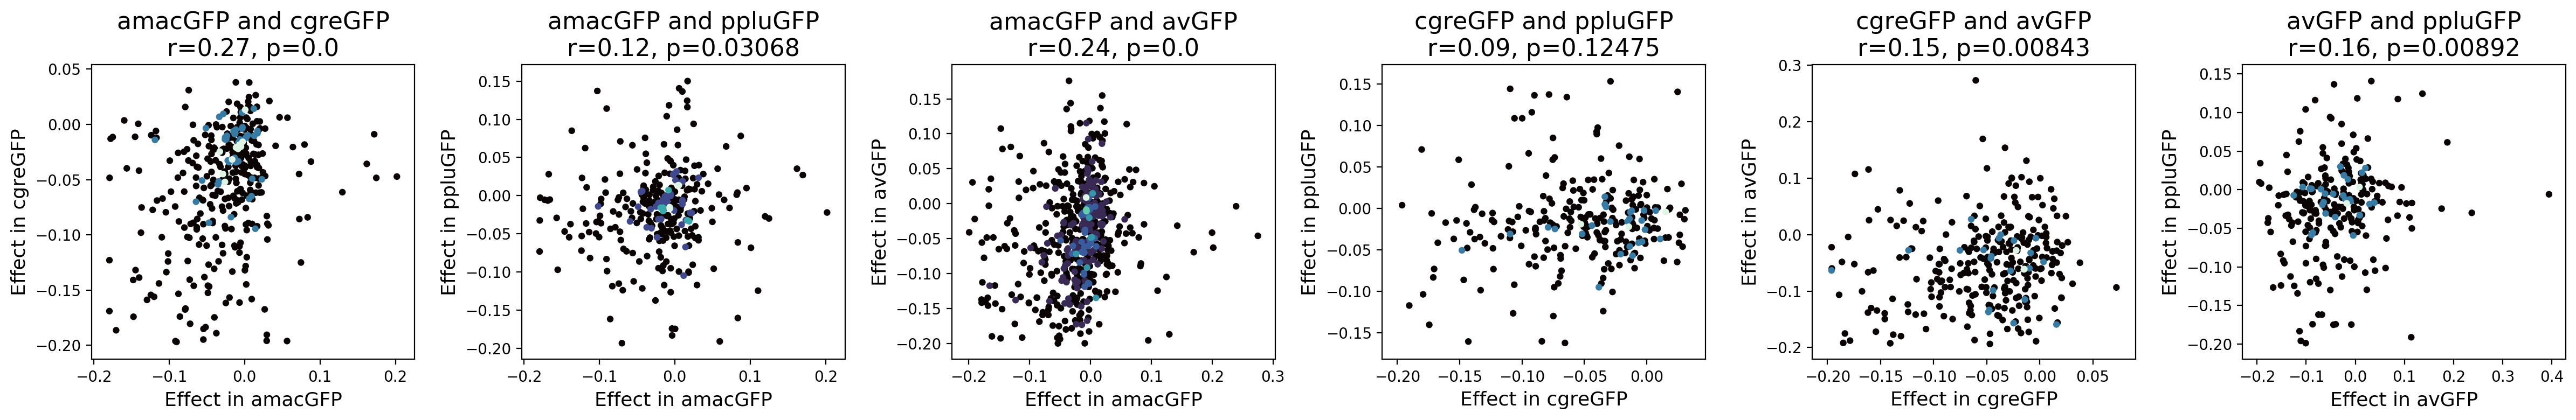

In [4]:
axes = subplots(nplots=6, nplots_per_row=6)
gene_pairs = [('amac','cgre'),('amac','pplu'),('amac','av'),('cgre','pplu'),('cgre','av'),('av','pplu')]

for ax,pair in zip(axes, gene_pairs):
    a = df_effects_singles[(df_effects_singles['effect_in_'+pair[0]]>-0.2) &
                          (df_effects_singles['effect_in_'+pair[1]]>-0.2)]['effect_in_'+pair[0]]
    b = df_effects_singles[(df_effects_singles['effect_in_'+pair[0]]>-0.2) &
                          (df_effects_singles['effect_in_'+pair[1]]>-0.2)]['effect_in_'+pair[1]]
    corr = scipy.stats.spearmanr(a,b, nan_policy='omit')
    plt.sca(ax)
    density_plot(np.array(a), np.array(b), s=20, cmap='mako')
    label_plot_axis(x = 'Effect in %sGFP' % pair[0], y = 'Effect in %sGFP' % pair[1],
                   t = '%sGFP and %sGFP\nr=%s, p=%s' % (pair[0], pair[1], round(corr[0],2), round(corr[1], 5)))
    
plt.tight_layout()

# Fraction of mutations which change effect across genes

In [3]:
def get_fraction_changed_effect(data, gene1, gene2, neutral_threshold, bad_threshold, mode='n2b'):
    # n2b = neutral in gene1, becomes deleterious in gene2
    # n2n =  neutral in gene1, remains neutral in gene2
    # b2n = deleterious in gene1, becomes neutral in gene1
    # b2b = deleterious in gene1, remains deleterious in gene2
    assert mode in ['n2b', 'n2n', 'b2n', 'b2b']
    
    df = data[['effect_in_'+gene1, 'effect_in_'+gene2]].dropna() # muts in df are observed in both genes
    df = df.reset_index()
    
    neutral_in_gene1_mask = df['effect_in_'+gene1] > neutral_threshold
    neutral_in_gene2_mask = df['effect_in_'+gene2] > neutral_threshold
    bad_in_gene1_mask = df['effect_in_'+gene1] < bad_threshold
    bad_in_gene2_mask = df['effect_in_'+gene2] < bad_threshold
    
    if mode =='n2b':
#         print(gene1, gene2, mode, len(df[neutral_in_gene1_mask]))
        return len(df[neutral_in_gene1_mask & bad_in_gene2_mask]) / len(df[neutral_in_gene1_mask])
    elif mode == 'n2n':
#         print(gene1, gene2, mode, len(df[neutral_in_gene1_mask]))
        return len(df[neutral_in_gene1_mask & neutral_in_gene2_mask]) / len(df[neutral_in_gene1_mask])
    elif mode == 'b2n':
#         print(gene1, gene2, mode, len(df[bad_in_gene1_mask]))
        return len(df[bad_in_gene1_mask & neutral_in_gene2_mask]) / len(df[bad_in_gene1_mask])
    elif mode == 'b2b':
#         print(gene1, gene2, mode, len(df[bad_in_gene1_mask]))
        return len(df[bad_in_gene1_mask & bad_in_gene2_mask]) / len(df[bad_in_gene1_mask])

In [4]:
effects = ['effect_in_av', 'effect_in_amac', 'effect_in_cgre', 'effect_in_pplu']
states = ['wt_state_av', 'wt_state_amac', 'wt_state_cgre', 'wt_state_pplu']
identities = {frozenset(['amac','av']):82, frozenset(['cgre','av']):41, frozenset(['pplu','av']):18,
              frozenset(['amac','cgre']):43, frozenset(['amac','pplu']):17, frozenset(['cgre','pplu']):19,
        frozenset(['amacV14L','av']):82, frozenset(['amacV14L','cgre']):43, frozenset(['amacV14L','pplu']):17,
             frozenset(['amac','amacV14L']):100}

In [5]:
sns.set(style='ticks')

''

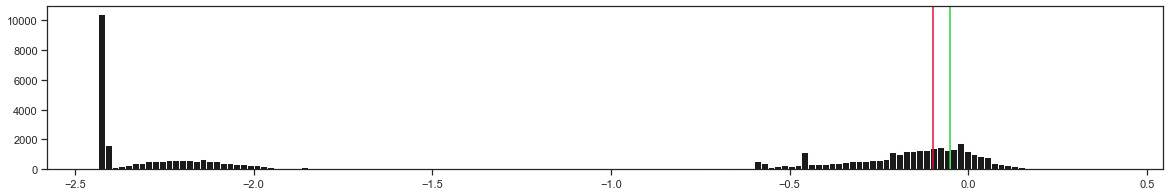

In [6]:
neutral_cutoff = -0.05
delet_cutoff = -0.1

plt.figure(figsize=[20,3])
plt.hist(data_aa[av_mask]['measured_effect'], bins=150, color='k')
plt.axvline(neutral_cutoff, color='limegreen')
plt.axvline(delet_cutoff, color='crimson')
;

In [7]:
def plot_fraction_changed_effect(data, neutral_threshold, bad_threshold, mode, se=75, sf=10):
    genes = ['amacV14L', 'amac', 'cgre', 'pplu', 'av', ]
    shapes = {'amac':'P', 'amacV14L':'X', 'cgre':'o', 'pplu':'s', 'av':'d'}
    gene_names = {'amac':'amacGFP', 'cgre':'cgreGFP', 'av':'avGFP', 'pplu':'ppluGFP2', 'amacV14L':'amacGFP:V14L'}
    xall = []
    yall = []
    for gene1 in genes:
        for gene2 in genes:
            if gene1 != gene2:
                x = 100 - identities[frozenset([gene1,gene2])]
                y = get_fraction_changed_effect(data, gene1, gene2, 
                                                neutral_threshold, bad_threshold, mode)
                xall.append(x)
                yall.append(y)
                plt.scatter(x, y, s=sf, color=colors[gene2], linewidth=0, marker='o')         
                
    plt.xticks([0,18,58,82])
    label_plot_axis(x = 'Sequence distance', y = 'Fraction of genotypes')
    plt.xlim(-2, 120)
    legendary([colors[gene] for gene in ['amacV14L','amacGFP','cgreGFP','ppluGFP', 'avGFP']], 
              ['amacV14L','amacGFP','cgreGFP','ppluGFP', 'avGFP'])
        
    return xall,yall

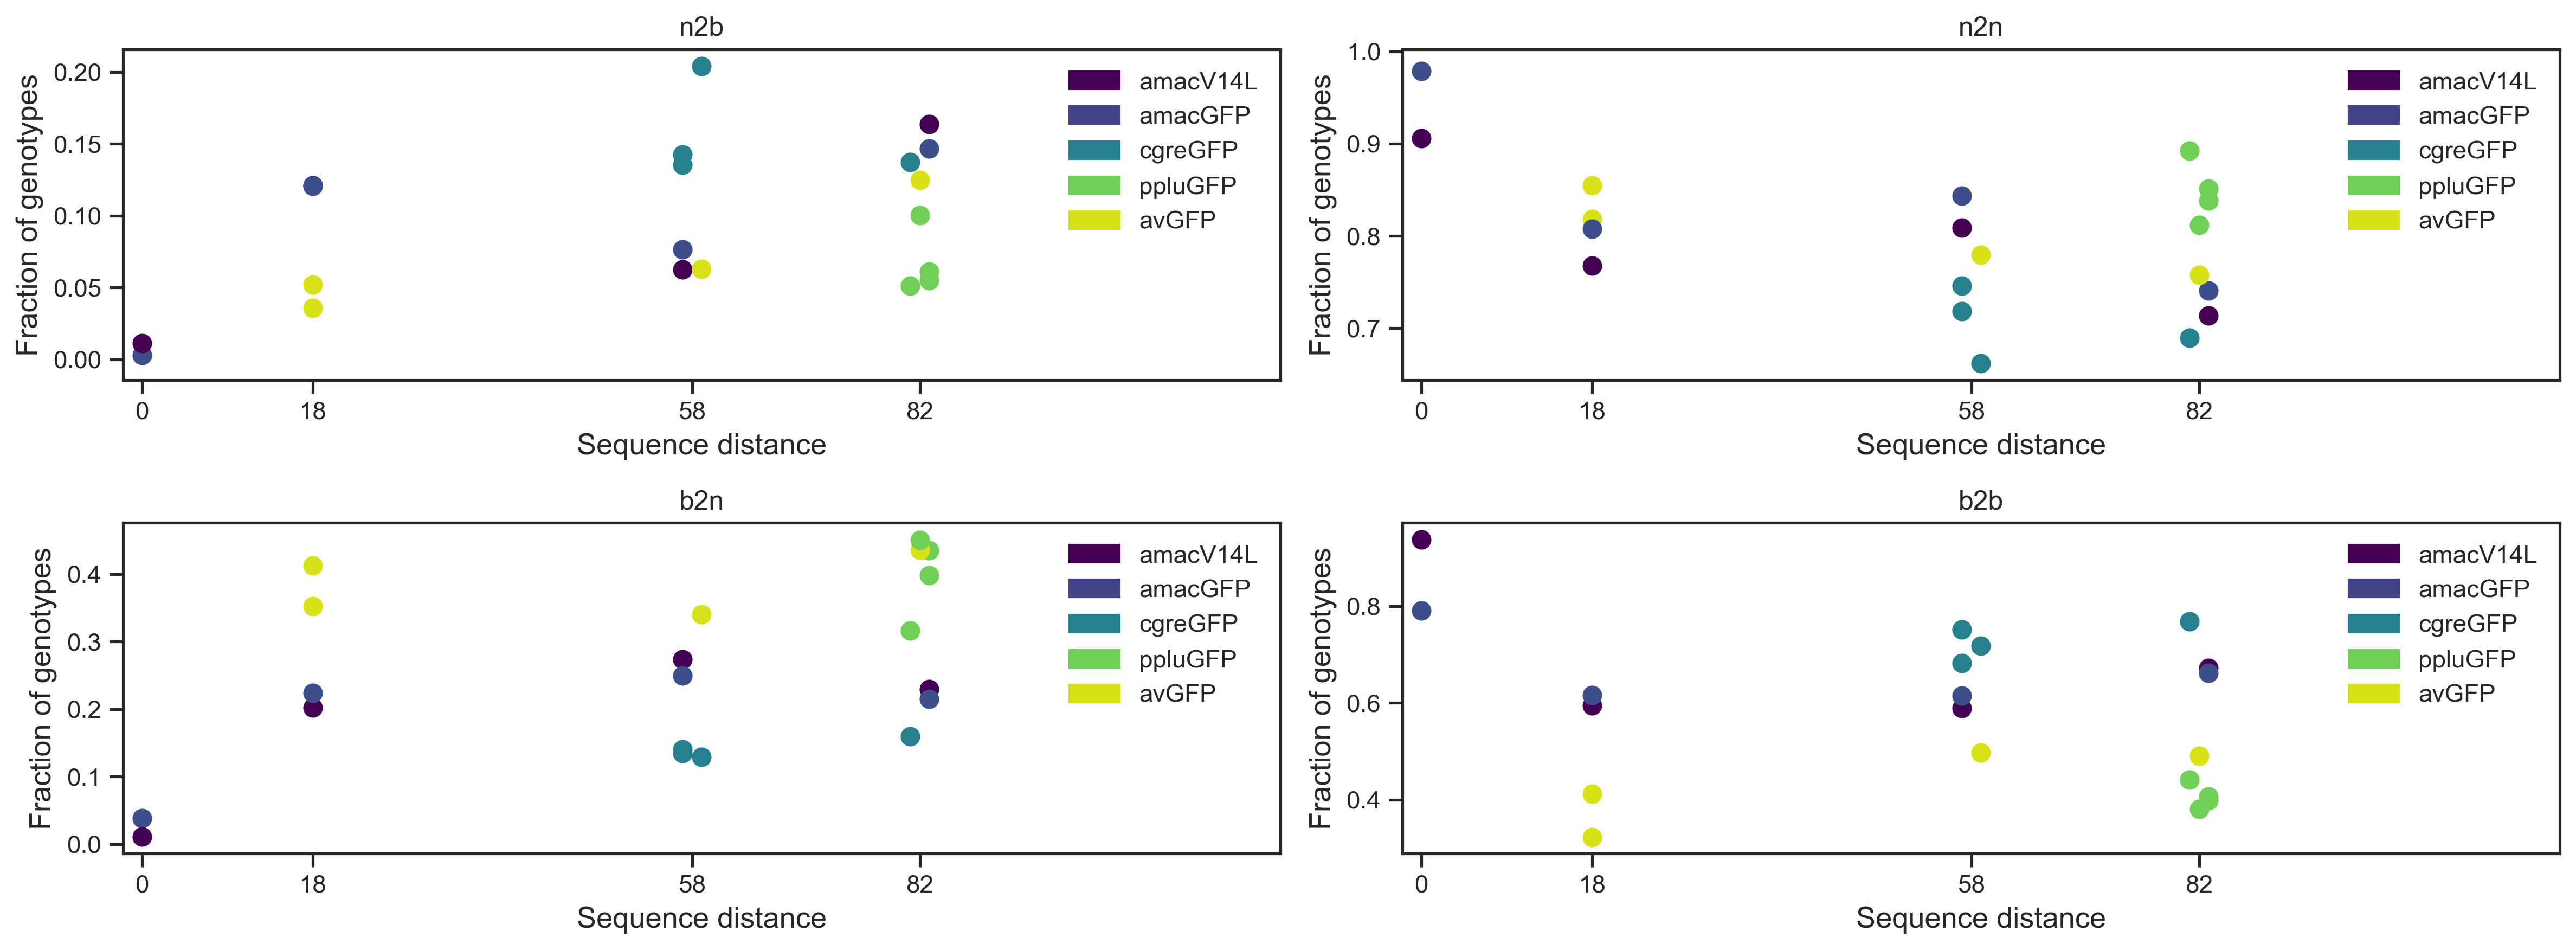

In [8]:
axes = subplots(height=3, width=8, nplots=4, nplots_per_row=2, dpi=300)
for ax,mode in zip(axes,['n2b', 'n2n', 'b2n', 'b2b']):
    plt.sca(ax)
    plot_fraction_changed_effect(df_effects_singles_scaled, neutral_cutoff, delet_cutoff, mode,se=300,sf=75,)
    plt.title(mode)
plt.tight_layout()

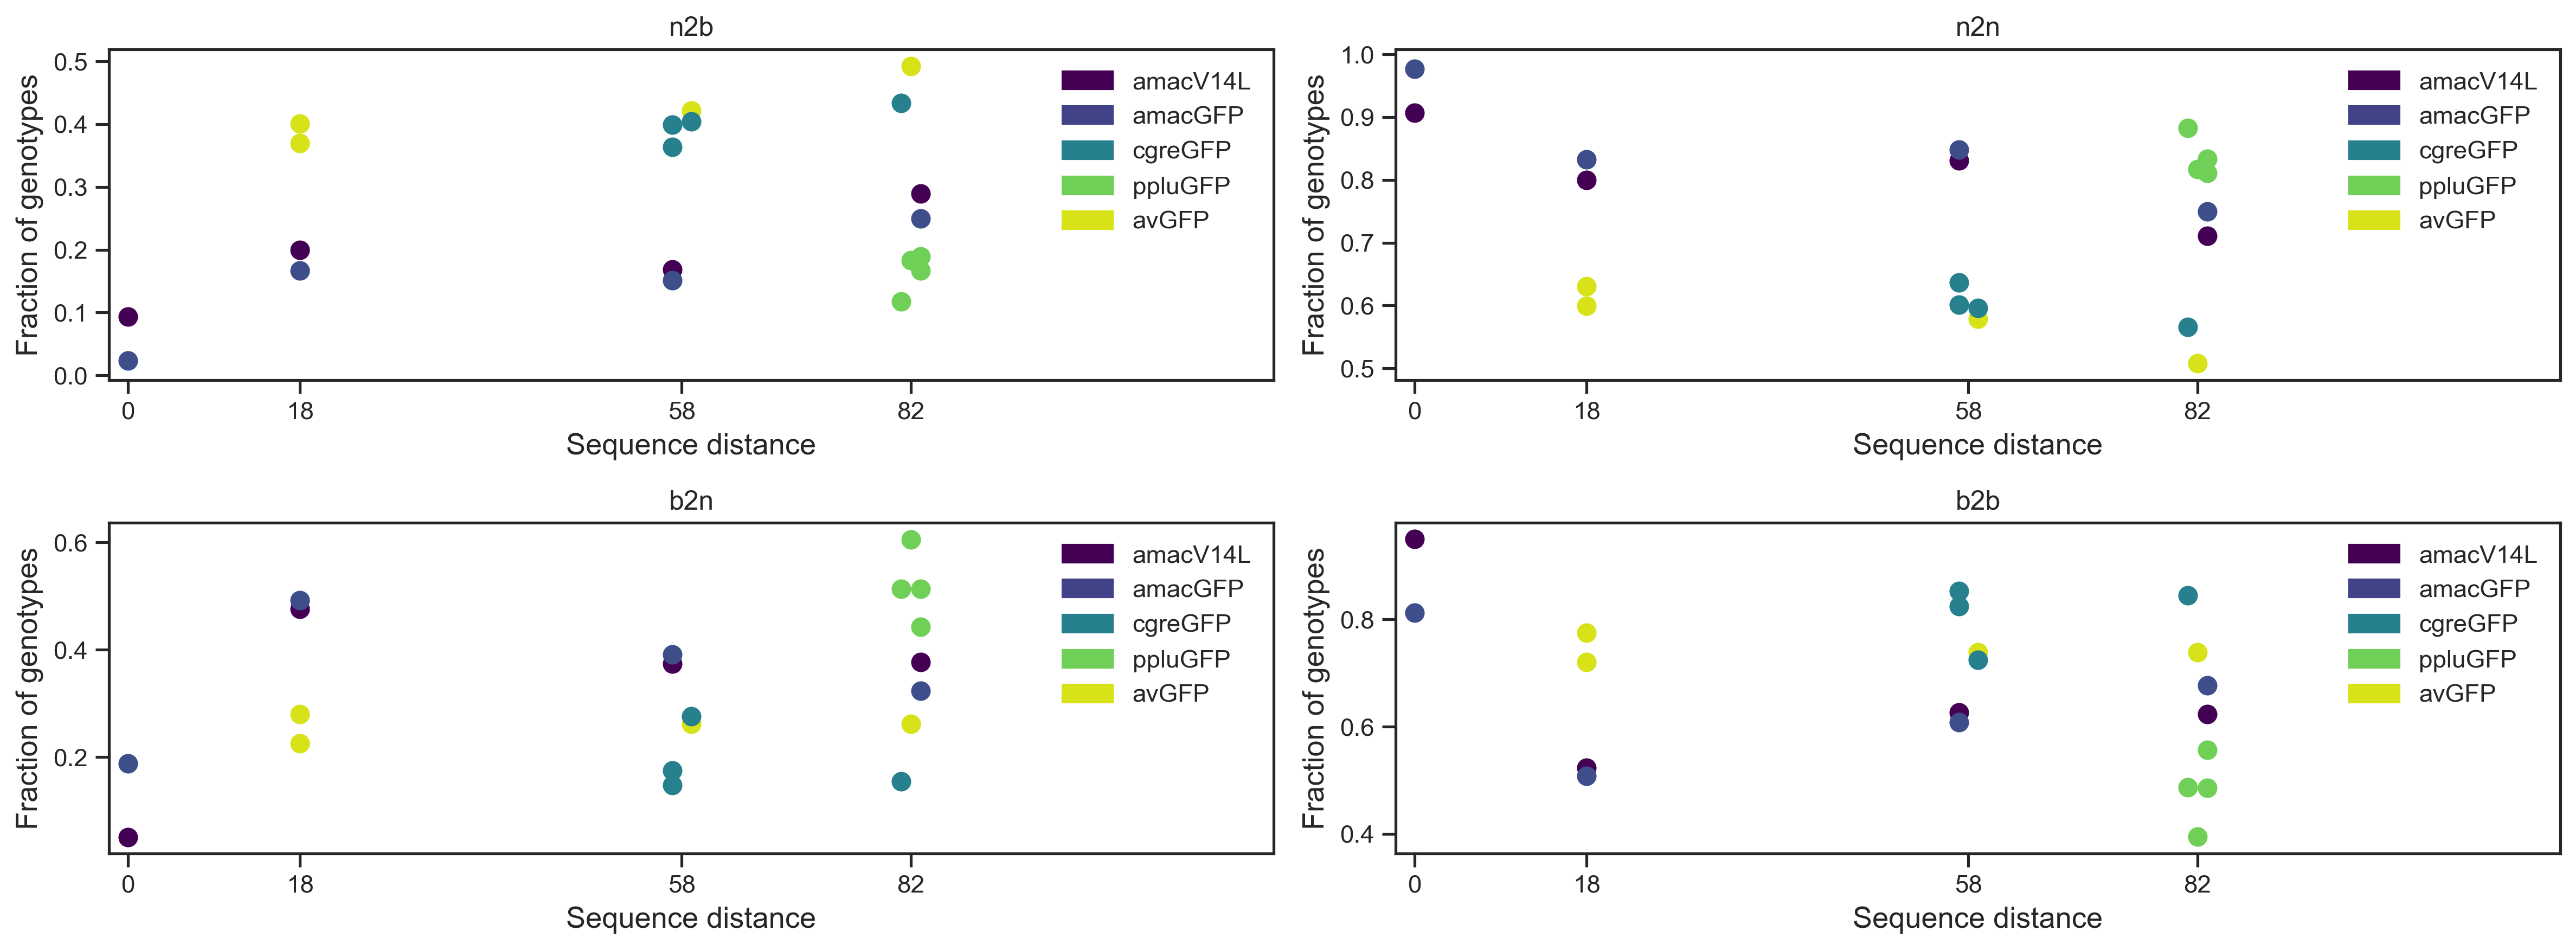

In [12]:
axes = subplots(height=3, width=8, nplots=4, nplots_per_row=2, dpi=300)
for ax,mode in zip(axes,['n2b', 'n2n', 'b2n', 'b2b']):
    plt.sca(ax)
    plot_fraction_changed_effect(df_effects_singles, -0.06, -0.06, mode,se=300,sf=75,)
    plt.title(mode)
plt.tight_layout()

### testing

In [79]:
def get_overall_fractions_noscaled(gene1, gene2, neutral_threshold, bad_threshold):
    df = df_effects_singles[['effect_in_'+gene1, 'effect_in_'+gene2]].dropna() # muts must be obsered in both genes
    df = df.reset_index()
    
    wts = {'amac' : 3.974485547944876, 'cgre' : 4.49832043653411, 'pplu' : 4.226492294827216,
          'amacV14L' : 3.9577171946556176, 'av' : 3.726358457799625}
    
    stds = {'amac' : 0.03148308406723709, 'cgre' : 0.02852658185221242, 'pplu' : 0.027489382693326424,
          'amacV14L' : 0.029670382945273337, 'av' : 0.0817635644945253}
    
    neutral_in_both_mask = (df['effect_in_'+gene1] > -stds[gene1]*neutral_threshold) & (
                                        df['effect_in_'+gene2] > -stds[gene2]*neutral_threshold)
    
    bad_in_both_mask = (df['effect_in_'+gene1] < -stds[gene1]*bad_threshold) & (
                                        df['effect_in_'+gene2] < -stds[gene2]*bad_threshold)
    
    changed_effect_mask = ((df['effect_in_'+gene1] > -stds[gene1]*neutral_threshold) & 
                            (df['effect_in_'+gene2] < -stds[gene2]*bad_threshold)) | (
                            (df['effect_in_'+gene2] > -stds[gene2]*neutral_threshold) & 
                            (df['effect_in_'+gene1] < -stds[gene1]*bad_threshold))
    
#     print('neutral in both', len(df[neutral_in_both_mask]) / len(df))
#     print('bad in both', len(df[bad_in_both_mask]) / len(df))
    print('changed effect', len(df[changed_effect_mask]), len(df))

    return {'nn' : len(df[neutral_in_both_mask]) / len(df) ,
           'bb' : len(df[bad_in_both_mask]) / len(df), 'bn' : len(df[changed_effect_mask]) / len(df)}

('amac', 'amacV14L')
changed effect 4 994
('amac', 'av')
changed effect 82 804
('amacV14L', 'av')
changed effect 81 724
('amac', 'cgre')
changed effect 66 563
('amacV14L', 'cgre')
changed effect 52 497
('av', 'cgre')
changed effect 84 510
('amac', 'pplu')
changed effect 47 410
('amacV14L', 'pplu')
changed effect 51 373
('pplu', 'av')
changed effect 36 353
('cgre', 'pplu')
changed effect 49 394


(0, 1)

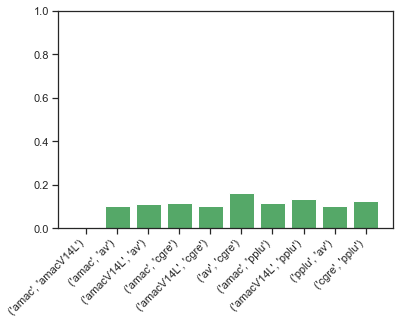

In [118]:
x = 0
pairs = [('amac','amacV14L'), ('amac','av'),('amacV14L','av'),
             ('amac','cgre'), ('amacV14L', 'cgre'), ('av','cgre'),
         ('amac','pplu'), ('amacV14L','pplu'), ('pplu','av'), ('cgre','pplu')]
for pair in pairs:
    print(pair)
    fracs = get_overall_fractions_noscaled(pair[0],pair[1],2,5)
    plt.bar(x, fracs['bn'], color='g')
#     plt.bar(x, fracs['bb'], bottom=fracs['bn'], color='r')
#     plt.bar(x, fracs['nn'], bottom=fracs['bn']+fracs['bb'], color='b')
    x += 1
    
plt.xticks(range(len(pairs)), pairs, rotation=45, ha='right')
plt.ylim(0,1)

In [56]:

for gene1 in ['amac','cgre','pplu','av']:
    for gene2 in ['amac','cgre','pplu','av']:
        if gene1==gene2:
            pass
        else:
            get_overall_fractions_noscaled(gene1, gene2, 1, 5)
            print()

neutral in both 0.19005328596802842
bad in both 0.1989342806394316
changed effect 0.08170515097690942

neutral in both 0.3170731707317073
bad in both 0.1048780487804878
changed effect 0.07317073170731707

neutral in both 0.39427860696517414
bad in both 0.06218905472636816
changed effect 0.05721393034825871

neutral in both 0.19005328596802842
bad in both 0.1989342806394316
changed effect 0.08170515097690942

neutral in both 0.1598984771573604
bad in both 0.13959390862944163
changed effect 0.06345177664974619

neutral in both 0.1843137254901961
bad in both 0.1411764705882353
changed effect 0.10588235294117647

neutral in both 0.3170731707317073
bad in both 0.1048780487804878
changed effect 0.07317073170731707

neutral in both 0.1598984771573604
bad in both 0.13959390862944163
changed effect 0.06345177664974619

neutral in both 0.32294617563739375
bad in both 0.0708215297450425
changed effect 0.0708215297450425

neutral in both 0.39427860696517414
bad in both 0.06218905472636816
changed 

In [63]:
wts = {'amac' : 3.970733, 'cgre' : 4.496914, 'pplu' : 4.225824,
          'amacV14L' : 3.960965, 'av' : 3.719212}

wt_stds = {'amac' : 0.03148308406723709, 'cgre' : 0.02852658185221242, 'pplu' : 0.027489382693326424,
          'amacV14L' : 0.029670382945273337, 'av' : 0.0817635644945253}

In [72]:
df_fractions = pd.DataFrame(columns=['gene','n_mut','n_total','n_dark','n_wt'])

i = 0
for gene in ['amac','amacV14L','cgre','pplu','av']:
    for nmut in range(1,8):
        ntotal = len(data_aa[(data_aa.gene==gene+'GFP') & (data_aa.n_mut==nmut)])
        nwt = len(data_aa[(data_aa.gene==gene+'GFP') & (data_aa.n_mut==nmut)
                         & (data_aa.brightness >= wts[gene]-2*wt_stds[gene])])
        threshold = 3 if gene=='av' else gate_borders_log[gene][0]
        ndark = len(data_aa[(data_aa.gene==gene+'GFP') & (data_aa.n_mut==nmut)
                         & (data_aa.brightness <= threshold)])
        df_fractions.loc[i] = [gene, nmut, ntotal, ndark, nwt]
        i += 1

In [75]:
df_fractions

,gene,n_mut,n_total,n_dark,n_wt
0,amac,1,1215,109,784
1,amac,2,11507,1285,5469
2,amac,3,12010,1855,4410
3,amac,4,6087,1363,1594
4,amac,5,2582,847,480
5,amac,6,1045,506,126
6,amac,7,395,227,34
7,amacV14L,1,1068,62,688
8,amacV14L,2,5621,603,2514
9,amacV14L,3,3010,506,968


In [76]:
# for gene1 in ['amac','amacV14L','cgre','pplu','av']:
#     for gene2 in ['amac','amacV14L','cgre','pplu','av']:
#         if gene1==gene2:
#             pass
#         else:
#             totals = {gene : dict(zip(df_fractions[df_fractions.gene==gene]['n_mut'],
#                              df_fractions[df_fractions.gene==gene]['n_total'])) for gene in [gene1,gene2]}
#             fwt = {gene : dict(zip(df_fractions[df_fractions.gene==gene]['n_mut'],
#                              df_fractions[df_fractions.gene==gene]['n_wt'])) for gene in [gene1,gene2]}
#             fdark = {gene : dict(zip(df_fractions[df_fractions.gene==gene]['n_mut'],
#                              df_fractions[df_fractions.gene==gene]['n_dark'])) for gene in [gene1,gene2]}
            
#             for nmut in range(1,8):
#                 print(gene1, gene2, f'{nmut} muts')
#                 print('wt-like fraction', scipy.stats.fisher_exact([
#                                             [fwt[gene1][nmut], totals[gene1][nmut] - fwt[gene1][nmut]],
#                                             [fwt[gene2][nmut], totals[gene2][nmut] - fwt[gene2][nmut]]]))
#                 print('dark fraction', scipy.stats.fisher_exact([
#                                             [fdark[gene1][nmut], totals[gene1][nmut] - fdark[gene1][nmut]],
#                                             [fdark[gene2][nmut], totals[gene2][nmut] - fdark[gene2][nmut]]]))
#                 print()